In [544]:
import pandas as pd
import shap
from pprint import pprint
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from scipy.stats import kendalltau
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, f1_score
from pyensembl import EnsemblRelease

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# save label encoder to global scope
le = LabelEncoder()
NUMBER_OF_BOOTSTRAPS = 5

In [372]:
ensemble_data = EnsemblRelease(97)
ensemble_data.download()
ensemble_data.index()

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/vtysch/Library/Caches/pyensembl/GRCh38/ensembl97/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/vtysch/Library/Caches/pyensembl/GRCh38/ensembl97/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/vtysch/Library/Caches/pyensembl/GRCh38/ensembl97/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle


In [ ]:
def merge_datasets():
    expressions = pd.read_csv('./../data/input/expressions/by_animal_class/Mammalia.tsv', sep='\t')
    samples = pd.read_csv('./../data/input/samples.tsv', sep="\t", index_col=None, dtype=None)
    species = pd.read_csv('./../data/input/species.tsv', sep='\t', index_col=None, dtype=None)

    samples = samples.set_index('run')
    species = species.set_index('species')
    expressions_T = expressions.T
    expressions_T = expressions_T.rename(columns=expressions_T.iloc[0]).drop(expressions_T.index[0])
    expressions_T.to_csv('transposed_expressions.csv')
    joined_samples_expressions = expressions_T.join([samples], how='inner')
    cross_species_joined_df = joined_samples_expressions.merge(species, left_on='species', right_on=species.index)
    for i, column in enumerate(species_data.columns):
        # put NaNs for columns with ; inside numeric values
        if 'ENSG' in column: 
            species_data[column] = pd.to_numeric(species_data[column], errors='coerce')
    cross_species_joined_df.to_csv('cross_species_df_merged.csv', index=False)
    
merge_datasets()


In [606]:
def add_metrics(current_metrics, model, ground_truth_X, ground_truth_Y):
    predictions = model.predict(ground_truth_X, num_iteration=model.best_iteration)
    test_y = ground_truth_Y
    fold_metrics = calculate_metrics(test_y, predictions)
    return np.add(current_metrics, np.array(list(fold_metrics.values())))

def regression_model_lightgbm(X_train, X_test, y_train, y_test, categorical):
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=[categorical])
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'max_leaves': 20,
        'max_depth': 3,
        'learning_rate': 0.07,
        'feature_fraction': 0.8,
        'bagging_fraction': 1,
        'min_data_in_leaf': 6,
        'lambda_l1': 0.9,
        'lambda_l2': 0.9,
        "verbose": -1
    }

    gbm = lgb.train(params,
        lgb_train,
        num_boost_round=500,
        valid_sets=lgb_eval,
        evals_result=evals_result,
        verbose_eval=1000,
        early_stopping_rounds=7)
    
    return gbm

def regression_for_interaction(X_train, y_train, categorical):
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=[categorical])

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'max_leaves': 20,
        'max_depth': 3,
        'learning_rate': 0.07,
        'feature_fraction': 0.8,
        'bagging_fraction': 1,
        'min_data_in_leaf': 6,
        'lambda_l1': 0.9,
        'lambda_l2': 0.9,
    }

    gbm = lgb.train(params,
        lgb_train,
        num_boost_round=30)
    
    return gbm

In [465]:
def sorted_stratification(X, Y, k):
    X['target'] = Y
    X = X.sort_values(by=['target'])
    partition_indexes = [[] for i in range(k)]
    i = 0
    index_of_sample = 0
   
    while i < (int(len(Y)/k)): 
        for j in range(k):
            partition_indexes[j].append((i*k)+j)
            index_of_sample = (i*k)+j
        i+=1

    index_of_sample += 1
    i = 0
    while index_of_sample < len(Y):
        partition_indexes[i].append(index_of_sample)
        index_of_sample += 1
        i+=1
        
    X_features = X.drop(['target'], axis=1)
    Y = X['target'].values
    X = X.drop(['target'], axis=1)    
        
    partition_Xs = []
    partition_Ys = []
    for pindex in partition_indexes:
        partition_Xs.append(X_features.iloc[pindex])
        partition_Ys.append(Y[pindex])
       
    return X, Y, partition_Xs, partition_Ys

In [505]:
def calculate_stable_shap_values(X, Y, index_of_categorical, label_to_predict):
    weight_of_features = []
    shap_values_out_of_fold = [[0 for i in range(len(X.values[0]))] for z in range(len(X))]
    #interaction_values_out_of_fold = [[[0 for i in range(len(X.values[0]))] for i in range(len(X.values[0]))] for z in range(len(X))]
    out_of_folds_metrics = [0, 0, 0]
    
    X, Y, partitions_of_X, partitions_of_Y = sorted_stratification(X, Y, NUMBER_OF_BOOTSTRAPS)
    
    
    for i in range(NUMBER_OF_BOOTSTRAPS):
        X_test = partitions_of_X[i]
        y_test = partitions_of_Y[i]

        X_train = pd.concat(partitions_of_X[:i] + partitions_of_X[i+1:])
        y_train = np.concatenate(partitions_of_Y[:i] + partitions_of_Y[i+1:], axis=0)
    
        # get trained model and record accuracy metrics
        model = regression_model_lightgbm(X_train, X_test, y_train, y_test, index_of_categorical)
        out_of_folds_metrics = add_metrics(out_of_folds_metrics, model, X_test, y_test)

        weight_of_features.append(model.feature_importance(importance_type='gain'))
        print(model.feature_importance(importance_type='gain'))
        
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
        #interaction_values = explainer.shap_interaction_values(X)
        shap_values_out_of_fold = np.add(shap_values_out_of_fold, shap_values)
        #interaction_values_out_of_fold = np.add(interaction_values_out_of_fold, interaction_values)
        
    # print average metrics results
    print('Accuracy of predicting ' + label_to_predict, np.divide(out_of_folds_metrics, NUMBER_OF_BOOTSTRAPS))
    
     # calculate shap values out of fold
    shap_values_out_of_fold = shap_values_out_of_fold / NUMBER_OF_BOOTSTRAPS
    shap_values_transposed = shap_values_out_of_fold.T
    X_transposed = X.T.values
        
    # get features that have stable weight across bootstraps
    output_features_by_weight = []
    for i, index_of_col in enumerate(weight_of_features[0]):
        cols = []
        for sample in weight_of_features:
            cols.append(sample[i])
        non_zero_cols = 0
        for col in cols:
            if col != 0:
                non_zero_cols += 1
        if non_zero_cols == NUMBER_OF_BOOTSTRAPS:
            output_features_by_weight.append({
                'ids': X.columns[i],
                'gain_score_to_'+label_to_predict: np.mean(cols),
                'name': ensemble_data.gene_name_of_gene_id(X.columns[i]),
                'kendall_tau_to_'+label_to_predict: kendalltau(shap_values_transposed[i], X_transposed[i], nan_policy='omit')[0]
            })
    
    #output_features_by_weight = sorted(output_features_by_weight, key=lambda k: k['score'], reverse=True) 
        
    return {'list_of_weighted_features': output_features_by_weight,
            'stable_shap_values': shap_values_out_of_fold}


In [506]:
def plot_shap_values(shap_values, X):
    shap_feature_names = []
    X_display = X.copy()
    X_display['tissue_encoded'] = le.inverse_transform(X_display['tissue_encoded'].values)
    for col in X.columns:
        if 'ENSG' in col:
            shap_feature_names.append(ensemble_data.gene_name_of_gene_id(col))
        else:
            shap_feature_names.append(col)
            
    shap.summary_plot(shap_values, X, feature_names=shap_feature_names)
    shap.dependence_plot("VARS2", shap_values, X, interaction_index='tissue_encoded', feature_names=shap_feature_names, display_features=X_display)


In [532]:
def calculate_metrics(prediction, ground_truth):
     return {
            'R2': r2_score(ground_truth, prediction),
            'MSE': mean_squared_error(ground_truth, prediction),
            'MAE': mean_absolute_error(ground_truth, prediction),
     }
    
def encode_tissues(dataframe):
    le.fit(dataframe['tissue'].values)
    tissues_encoded = le.transform(dataframe['tissue'].values)
    dataframe['tissue_encoded'] = tissues_encoded
    
    return dataframe
    
    
def split_to_X_and_Y(dataframe, label_to_predict):
    X = dataframe.drop([label_to_predict, 'tissue'], axis=1)
    Y = dataframe[label_to_predict].values
    index_of_categorical_feature = list(X.columns).index('tissue_encoded')

    return X, X_values, Y, index_of_categorical_feature
    
    
def get_predictions(label_to_predict):
    species_data = pd.read_csv('cross_species_df_merged.csv', low_memory=False)
    
    # remove other features (redundant and those that correlate with target)
    cols_to_delete = []
    for column in list(species_data.columns):
        if 'ENSG' not in column and column not in ['tissue', label_to_predict]:
            cols_to_delete.append(column)
            
    species_data = species_data.drop(cols_to_delete, axis=1) 
    
    species_data = species_data[(~pd.isnull(species_data[label_to_predict]))] # select only row where target is set
    species_data = species_data.dropna(axis=1, thresh=int(len(species_data)*0.9)) # remove all genes where percentage of NaN > 10%
    species_data = species_data[species_data['tissue'].isin(['Lung', 'Liver', 'Kidney', 'Brain', 'Blood'])] # remove underrepresented tissues
    species_data = encode_tissues(species_data)
    
    feature_df, X, Y, index_of_categorical = split_to_X_and_Y(species_data, label_to_predict)
    
    object_from_training = calculate_stable_shap_values(feature_df, Y, index_of_categorical, label_to_predict)
    
    features_weighted = object_from_training['list_of_weighted_features']
    shap_values = object_from_training['stable_shap_values']
    
    return shap_values, feature_df, features_weighted


In [533]:
list_of_weighted_features = []
list_of_shap_values = []
list_of_dataframes = []

for label in ['gestation_days', 'lifespan', 'mass_g', 'temperature_kelvin', 'metabolic_rate']:
    shap_values, feature_df, weighted_features = get_predictions(label)
    list_of_weighted_features += weighted_features
    list_of_shap_values.append(shap_values)
    list_of_dataframes.append(feature_df)

Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [9062]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[139]	valid_0's l1: 12.8863	valid_0's l2: 598.588


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [9062]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[157]	valid_0's l1: 13.2322	valid_0's l2: 734.354


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [9062]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 11.0448	valid_0's l2: 395.753


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [9062]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 9.74365	valid_0's l2: 400.381


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [9062]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[163]	valid_0's l1: 16.8447	valid_0's l2: 1345.39


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Accuracy of predicting gestation_days [  0.90782648 694.89429737  12.75033927]


Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [9283]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[137]	valid_0's l1: 3.08995	valid_0's l2: 59.9258


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [9283]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[237]	valid_0's l1: 3.11414	valid_0's l2: 70.0752


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [9283]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[439]	valid_0's l1: 4.3758	valid_0's l2: 113.283


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [9283]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[95]	valid_0's l1: 3.34457	valid_0's l2: 99.1796


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [9283]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[116]	valid_0's l1: 2.22765	valid_0's l2: 17.8959


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Accuracy of predicting lifespan [ 0.79418439 72.07191589  3.2304237 ]


Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [12039]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[87]	valid_0's l1: 2319.88	valid_0's l2: 6.54532e+07


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [12039]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[86]	valid_0's l1: 2602.9	valid_0's l2: 4.01704e+07


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [12039]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 3438.37	valid_0's l2: 7.08048e+07


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [12039]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[130]	valid_0's l1: 2470.31	valid_0's l2: 3.00412e+07


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [12039]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[89]	valid_0's l1: 1504.43	valid_0's l2: 2.72511e+07


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Accuracy of predicting mass_g [9.89171031e-01 4.67441286e+07 2.46717961e+03]


Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [8740]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[164]	valid_0's l1: 0.161098	valid_0's l2: 0.0723359


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [8740]


Training until validation scores don't improve for 7 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.191471	valid_0's l2: 0.176654


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [8740]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[127]	valid_0's l1: 0.159769	valid_0's l2: 0.0844219


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [8740]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[152]	valid_0's l1: 0.169584	valid_0's l2: 0.120548


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [8740]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[159]	valid_0's l1: 0.185334	valid_0's l2: 0.0881763


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Accuracy of predicting temperature_kelvin [0.9641512  0.10842622 0.17345072]


Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [12039]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 4.51642	valid_0's l2: 111.878


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [12039]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[121]	valid_0's l1: 1.46253	valid_0's l2: 31.4603


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [12039]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 4.49759	valid_0's l2: 190.969


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [12039]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[118]	valid_0's l1: 2.39296	valid_0's l2: 39.1278


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [12039]


Training until validation scores don't improve for 7 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 4.54041	valid_0's l2: 94.6226


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Accuracy of predicting metabolic_rate [ 0.97260933 93.61152914  3.48198367]


In [534]:
pprint(len(list_of_weighted_features))

81


In [603]:
aggregated_list_of_features = {}
uniq_gene_ids = list(set([l['ids'] for l in list_of_weighted_features]))
for gid in uniq_gene_ids:
    obj = {
        'name': '',
        'gain_score_to_gestation_days': 0,
        'kendall_tau_to_gestation_days': 0,
        'gain_score_to_lifespan': 0,
        'kendall_tau_to_lifespan': 0,
        'gain_score_to_mass_g': 0,
        'kendall_tau_to_mass_g': 0,
        'gain_score_to_temperature_kelvin': 0,
        'kendall_tau_to_temperature_kelvin': 0,
        'gain_score_to_metabolic_rate': 0,
        'kendall_tau_to_metabolic_rate': 0
    }
    aggregated_list_of_features[gid] = obj
    
for el in list_of_weighted_features:
    aggregated_list_of_features[el['ids']].update(el)
            
pprint(aggregated_list_of_features)

{'ENSG00000004779': {'gain_score_to_gestation_days': 0,
                     'gain_score_to_lifespan': 0,
                     'gain_score_to_mass_g': 0,
                     'gain_score_to_metabolic_rate': 0,
                     'gain_score_to_temperature_kelvin': 6.833599391780444,
                     'ids': 'ENSG00000004779',
                     'kendall_tau_to_gestation_days': 0,
                     'kendall_tau_to_lifespan': 0,
                     'kendall_tau_to_mass_g': 0,
                     'kendall_tau_to_metabolic_rate': 0,
                     'kendall_tau_to_temperature_kelvin': 0.1254506451633564,
                     'name': 'NDUFAB1'},
 'ENSG00000005007': {'gain_score_to_gestation_days': 0,
                     'gain_score_to_lifespan': 0,
                     'gain_score_to_mass_g': 0,
                     'gain_score_to_metabolic_rate': 0,
                     'gain_score_to_temperature_kelvin': 0.816319592949003,
                     'ids': 'ENSG00000005007',
 

In [586]:
len(pd.DataFrame(list(aggregated_list_of_features.values())).sort_values(by=['name']))

73

In [585]:
pd.DataFrame(list(aggregated_list_of_features.values())).sort_values(by=['name']).to_csv('significant_gene_results.csv')

### Building new model for predicting lifespan with variables + selected genes

In [607]:
def get_interactions_by_selected_features(ids, label_to_predict):
    species_data = pd.read_csv('cross_species_df_merged.csv', low_memory=False)
    
    # remove other features (redundant and those that correlate with target)
    cols_to_delete = []
    for column in list(species_data.columns):
        if column not in ids and column not in ['tissue', 'gestation_days', 'lifespan', 'mass_g', 'temperature_kelvin', 'metabolic_rate']:
            cols_to_delete.append(column)
            
    species_data = species_data.drop(cols_to_delete, axis=1) 
    
    #species_data = species_data[(~pd.isnull(species_data[label_to_predict]))] # select only row where target is set
    #species_data = species_data.dropna(axis=1, thresh=int(len(species_data)*0.9)) # remove all genes where percentage of NaN > 10%
    species_data = species_data[species_data['tissue'].isin(['Lung', 'Liver', 'Kidney', 'Brain', 'Blood'])] # remove underrepresented tissues
    species_data = encode_tissues(species_data)
    
    feature_df, X, Y, index_of_categorical = split_to_X_and_Y(species_data, label_to_predict)
    
    model = regression_for_interaction(feature_df, Y, index_of_categorical)
    print('R^2', calculate_metrics(model.predict(feature_df), Y))
    explainer = shap.TreeExplainer(model)
    interaction_values = explainer.shap_interaction_values(feature_df)
    shap_values = explainer.shap_values(feature_df)
    
    return shap_values, interaction_values, feature_df
    

In [608]:
shap_values, interaction_values, df = get_interactions_by_selected_features(list(aggregated_list_of_features.keys()), 'lifespan')


R^2 {'R2': 0.9670923289636344, 'MSE': 18.066276076854002, 'MAE': 3.12982645921581}


Using categorical_feature in Dataset.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [609]:
shap_feature_names = []
X_display = df.copy()
X_display['tissue_encoded'] = le.inverse_transform(X_display['tissue_encoded'].values)
for col in df.columns:
    if 'ENSG' in col:
        shap_feature_names.append(ensemble_data.gene_name_of_gene_id(col))
    else:
        shap_feature_names.append(col)

In [621]:
features_list = []
for i, col in enumerate(df.columns):
    ktau =  kendalltau(shap_values.T[i], df.T.values[i], nan_policy='omit')[0]
    if not np.isnan(ktau):
        features_list.append({'name': shap_feature_names[i], 'id': col, 'kendall_tau_to_lifespan': ktau})

In [627]:
features_list = sorted(features_list, key=lambda k: k['kendall_tau_to_lifespan'], reverse=True) 


In [628]:
for l in features_list:
    print(l['name'], l['id'], np.round(l['kendall_tau_to_lifespan'], 2))

HESX1 ENSG00000163666 0.73
gestation_days gestation_days 0.73
BPIFC ENSG00000184459 0.67
CEL ENSG00000170835 0.64
TRPV1 ENSG00000196689 0.62
CATSPER3 ENSG00000152705 0.62
CNOT9 ENSG00000144580 0.61
SPATA20 ENSG00000006282 0.59
MROH8 ENSG00000101353 0.58
DCTD ENSG00000129187 0.57
C7orf31 ENSG00000153790 0.52
IGFBP2 ENSG00000115457 0.46
ATP5PF ENSG00000154723 0.3
MEIOC ENSG00000180336 0.3
NDUFS5 ENSG00000168653 0.28
TYMP ENSG00000025708 0.19
metabolic_rate metabolic_rate 0.14
mass_g mass_g 0.08
NSF ENSG00000073969 0.01
PTPRK ENSG00000152894 -0.15
ATAT1 ENSG00000137343 -0.18
RPL35 ENSG00000136942 -0.28
temperature_kelvin temperature_kelvin -0.31
CHCHD3 ENSG00000106554 -0.34
MSRB1 ENSG00000198736 -0.34
TRIM39 ENSG00000204599 -0.35
ZDHHC4 ENSG00000136247 -0.38
NSDHL ENSG00000147383 -0.39
KPNA2 ENSG00000182481 -0.48
TMEM223 ENSG00000168569 -0.52
SWI5 ENSG00000175854 -0.53
ATP5MPL ENSG00000156411 -0.75


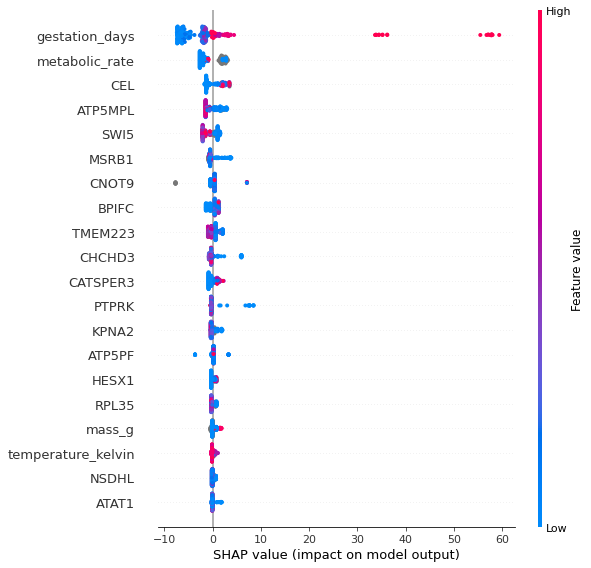

In [610]:
#shap.summary_plot('mass_g', shap_values, df)
shap.summary_plot(shap_values, df, feature_names=shap_feature_names)

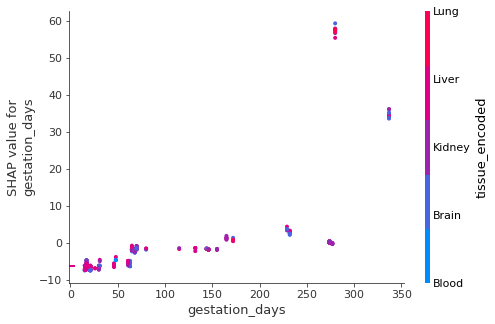

In [611]:
shap.dependence_plot("gestation_days", shap_values, df, interaction_index='tissue_encoded', feature_names=shap_feature_names, display_features=X_display)

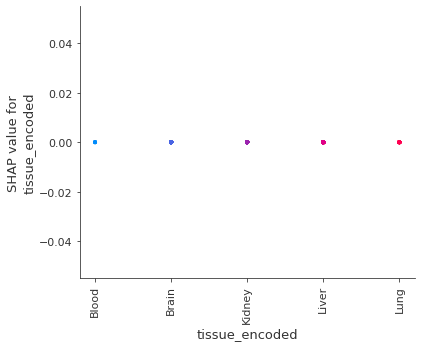

In [579]:
shap.dependence_plot("tissue_encoded", shap_values, df, interaction_index='tissue_encoded', feature_names=shap_feature_names, display_features=X_display)

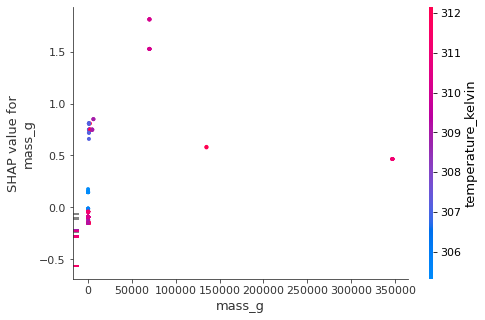

In [644]:
shap.dependence_plot("mass_g", shap_values, df, interaction_index='temperature_kelvin', feature_names=shap_feature_names, display_features=X_display)


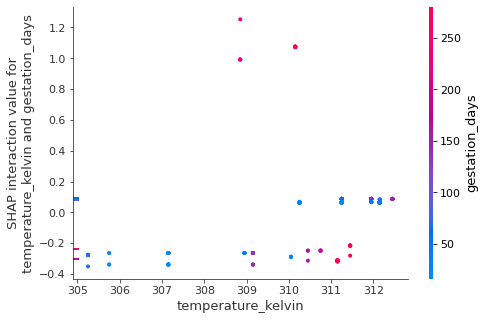

In [691]:
shap.dependence_plot(
    ("temperature_kelvin", "gestation_days"),
    interaction_values, df,
    display_features=df
)

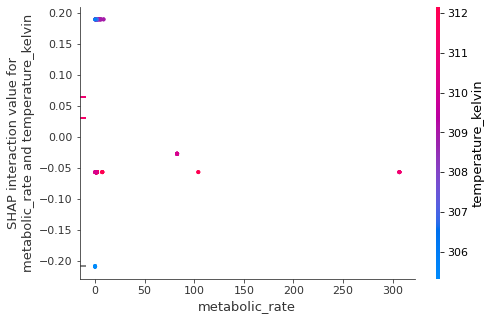

In [692]:
shap.dependence_plot(
    ("metabolic_rate", "temperature_kelvin"),
    interaction_values, df,
    display_features=df,
    feature_names=shap_feature_names
)

In [685]:
pprint(tmp2)

array([[  0.        ,  37.43459881, 249.30134534,  30.25208247,
         77.25582702,  46.78504629,  12.38447138,  34.08195936,
          7.48038372,  19.90076071, 114.35703266,  46.56489649,
         46.77540103,  26.80170184,  29.80138187,   0.        ,
          0.        ,   0.        ,  12.90350101,   0.        ,
         29.01795311,  15.08293097,  14.3457728 ,   1.88799884,
         17.34494482],
       [ 37.43459881,   0.        ,   0.        ,   0.        ,
         46.81452679,   0.        ,  96.00287688,   0.        ,
          0.        ,  39.69269844,   0.        ,  22.70983839,
         27.79895313,   0.        ,  16.49718403,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.87509904,   0.        ,   0.        ,
          0.        ],
       [249.30134534,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.    

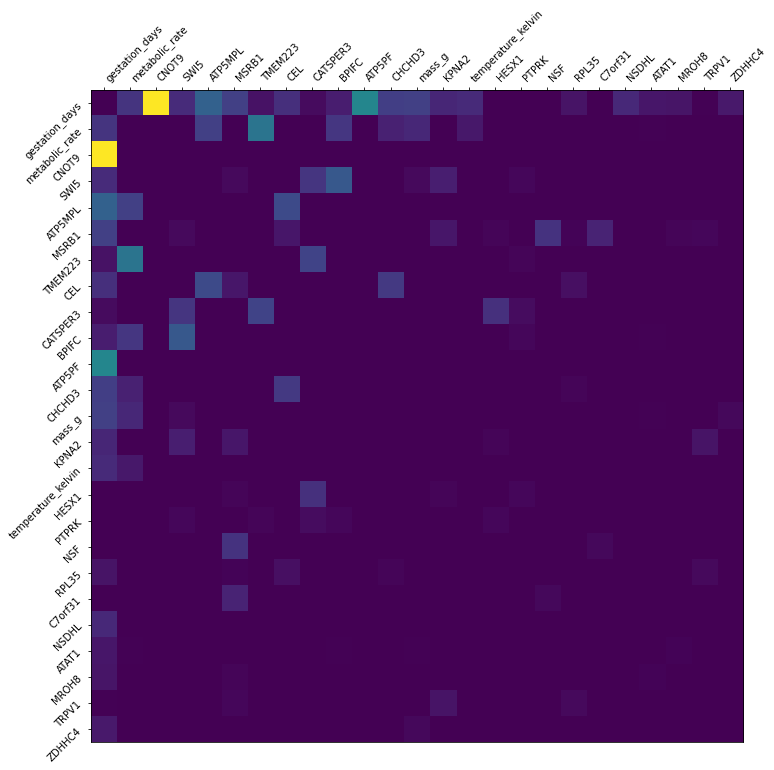

In [668]:
import matplotlib.pylab as pl
import numpy as np

tmp = np.abs(interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:25]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)

pl.yticks(range(tmp2.shape[0]), np.array(shap_feature_names)[inds], rotation=45, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), np.array(shap_feature_names)[inds], rotation=45, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

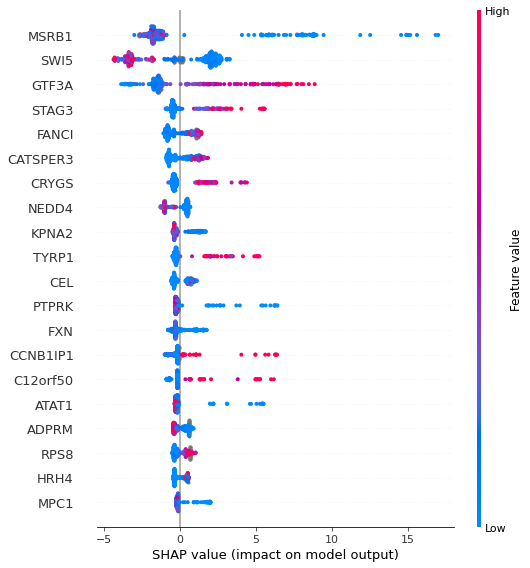

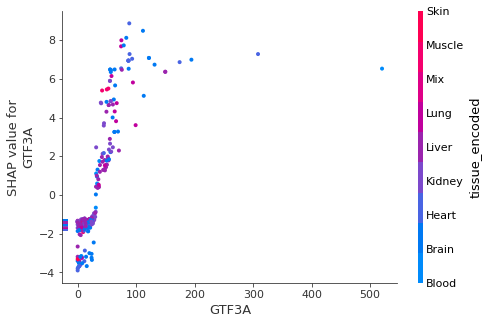

In [333]:
def plot_shap_values(shap_values, X):
    shap_feature_names = []
    X_display = X.copy()
    X_display['tissue_encoded'] = le.inverse_transform(X_display['tissue_encoded'].values)
    for col in X.columns:
        if 'ENSG' in col:
            shap_feature_names.append(ensemble_data.gene_name_of_gene_id(col))
        else:
            shap_feature_names.append(col)
            
    shap.summary_plot(shap_values, X, feature_names=shap_feature_names)
    shap.dependence_plot("GTF3A", shap_values, X, interaction_index='tissue_encoded', feature_names=shap_feature_names, display_features=X_display)

plot_shap_values(shap_values, feature_df)